In [ ]:
!pip install optuna


In [ ]:


import pandas as pd  # Manipulación y análisis de datos

import numpy as np

import tensorflow as tf  # Para construir y entrenar modelos de aprendizaje automático

import optuna  # Para la optimización de hiperparámetros en modelos de aprendizaje automático

from sklearn.model_selection import train_test_split  # División de datos en entrenamiento y prueba

from sklearn.preprocessing import StandardScaler  # Estandarización de características
#ajusta y transforma las características de modo que tengan una media de cero y una desviación estándar de uno
#lo que ayuda a los algoritmos de machine learning a funcionar de manera más eficiente y equitativa.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
'''
1. accuracy_score: Calcula la proporción de predicciones correctas sobre el total de predicciones realizadas.
2.precision_score:(precisión) Calcula la proporción de verdaderos positivos sobre el total de predicciones positivas realizadas.
3.recall_score:(exhaustividad) Calcula la proporción de verdaderos positivos sobre el total de casos positivos reales.
4.f1_score: Calcula la media armónica de la precisión y la exhaustividad.
  Es útil cuando se desea tener un equilibrio entre precisión y exhaustividad.
'''

from tensorflow.keras.models import Sequential  # Modelo de red neuronal secuencial

from tensorflow.keras.layers import Dense  # Capa densamente conectada
#Una capa densa, en el contexto de redes neuronales
#significa que cada neurona en esa capa está conectada a todas las neuronas de la capa anterior.

from tensorflow.keras.optimizers import Adam  # Optimizador Adam, Ayuda a disminuir el error entre iteraciones mas rapido

from tensorflow.keras.losses import CategoricalCrossentropy  # Función de pérdida para clasificación
# Esta función calcula la pérdida entre las etiquetas verdaderas y las predicciones del modelo.

from sklearn.preprocessing import MinMaxScaler  # Escalador Min-Max
#Ajusta a un rango específico, generalmente entre 0 y 1

SEED = 7
tf.random.set_seed(SEED)# Es una funcion de tensor flow para generar los numeros aleatoriamente

datos = pd.read_csv("/content/sample_data/Temp_Asu20092021 (2).csv") #Carga el conjunto de datos

datos['Fecha'] = pd.to_datetime(datos['Fecha']) # Convertir la columna 'Fecha' al tipo datetime

# Hacer que la 'Fecha' sea el índice
datos.set_index('Fecha', inplace=True)#Quiere decir que la fecha es el valor clave para las filas
#Cada fila se identificaria con una fecha especifica
datos = datos[datos.index.year >= 2019] #Filtra los datos y pone solo lo del año 2019 para adelante

datos_interpolados = datos.resample('H').interpolate(method='spline', order=3) # Ordena segun H, horas e interpola mediante Spline cubicos
datos_interpolados.dropna(inplace=True)#Elimina los datos NA


# CALCULAR EL MÁXIMO DE CADA DÍA
max_temperaturas_diarias = datos_interpolados.resample('D').max()['Temperatura'] #Resample ordena los datos por Dia y luego
#Max() buscar el maximo valor de esa agrupacion por dias, de que columna? De la columna ['Temperatura']

datos_interpolados['Max_Temperatura_Dia'] = datos_interpolados.groupby(datos_interpolados.index.date)['Temperatura'].transform('max')
'''
groupby para agrupar los datos por fecha y luego aplica la función max() para calcular la temperatura máxima de cada día.
La función transform('max') asigna el valor máximo de temperatura de cada grupo a cada fila correspondiente en la columna 'Max_Temperatura_Dia'.
'''

# Aplicar corte de cuartil a las temperaturas máximas diarias
cuartiles = max_temperaturas_diarias.quantile([0.25, 0.5, 0.75])

# Definir categorías basadas en los cuartiles
umbral_frio = cuartiles[0.25]
umbral_bueno = cuartiles[0.5]
umbral_caliente = cuartiles[0.75]

# Asignar cada observación de temperatura a su categoría correspondiente
datos_interpolados['Categoria_Temperatura'] = pd.cut(datos_interpolados['Temperatura'],
                                                     bins=[-float('inf'), umbral_frio, umbral_bueno,
                                                           umbral_caliente, float('inf')],
                                                     labels=['Frío', 'Bueno', 'Caliente', 'Muy Caliente'])

#pd.cut segmenta datos, que datos?. el primer elemento datos_interpolados['Temperatura'], en que segmentos?, desde menos infinito hasta frio
# de frio a bueno, de bueno a caliente y de caliente a infinito y los etiqueda en labels, 'Frío', 'Bueno', 'Caliente' y 'Muy Caliente'


# Desplazar para obtener la temperatura del siguiente día
datos_interpolados['Temperatura_Siguiente_Dia'] = datos_interpolados['Categoria_Temperatura'].shift(-24)
#Crea una columna llamada 'Temperatura_Siguiente_Dia' y usa shift para desplazar 24 horas de la temperatura de los dias


# USAR ONE HOT ENCODING
datos_codificados = pd.get_dummies(datos_interpolados, columns=['Categoria_Temperatura'])
#Crea una codificacion entre 0 y 1 para la columna 'Categoria_Temperatura'
#Por ejemplo, si teníamos las categorías 'Frío', 'Bueno', 'Caliente' y 'Muy Caliente'
#el one-hot encoding crearía cuatro nuevas columnas, una para cada categoría,
#y asignaría un valor de 1 en la columna correspondiente a la categoría de la observación y 0 en las demás columnas.
#Esto facilita el manejo de variables categóricas en los modelos de aprendizaje automático.


# Definir características y variable objetivo
X = datos_interpolados[['Temperatura', 'Max_Temperatura_Dia']]
y = datos_codificados[['Categoria_Temperatura_Frío', 'Categoria_Temperatura_Bueno',
                       'Categoria_Temperatura_Caliente', 'Categoria_Temperatura_Muy Caliente']]
#Se crean las dos variables que se van a utilizar para el aprendizaje del modelo, x tiene 2 caracterizticas y y tiene 4

# Normalizar características numéricas
scaler = StandardScaler()
X_escalado = scaler.fit_transform(X)
#utiliza la clase StandardScaler del módulo sklearn.preprocessing para estandarizar las características X.

# Dividir datos en conjuntos de entrenamiento y validación
indices_entrenamiento = (datos_interpolados.index.year <= 2019) #contiene valores True o False dependiendo
#de si el año correspondiente en el índice de datos_interpolados es menor o igual a 2019.

indices_validacion = ((datos_interpolados.index.year >= 2020) & (datos_interpolados.index.year <= 2020))
'''
Esta línea crea un arreglo booleano indices_validacion, que contiene valores True o False dependiendo
de si el año correspondiente en el índice de datos_interpolados está entre 2020 y 2020, inclusive.
'''

X_entrenamiento, X_validacion = X_escalado[indices_entrenamiento], X_escalado[indices_validacion]
#Esta línea divide el conjunto de datos escalado X_escalado en dos partes: X_entrenamiento y X_validacion

y_entrenamiento, y_validacion = y.values[indices_entrenamiento], y.values[indices_validacion]
#Divide los valores de Y en y_entrenamientos y y_validacion usando los indices hallados

# Definir función objetivo para Optuna
def objetivo(trial):
    # Definir hiperparámetros a ajustar
    num_capas = 1 #se está utilizando una red neuronal con una sola capa oculta.

    num_unidades = trial.suggest_categorical('num_unidades', [32, 64, 128]) #Sugiere la cant de valores tomados para las capas ocultas
    tasa_aprendizaje = trial.suggest_loguniform('tasa_aprendizaje', 1e-4, 1e-2) #Sugiere los valores de la tasa de aprendizaje para el mayor
    #rendimiento y la convergencia mas rapida mientras mas pequeño mas lento la convergencia pero un valor muy alto puede producir demasiadas
    #oscilaciones

    # Definir la arquitectura del modelo
    modelo = Sequential() #Se crea un modelo secuencial. Esto significa que las capas de la red se apilan linealmente.
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X.shape[1],)))#Se agrega la primera capa densa como la capa de entrada
    #usa la función de activación relu y se define la forma de entrada (input_shape) basada en el número de características de X.
    #introduce no linealidad en una red neuronal al devolver cero para valores negativos y el mismo valor para valores positivos.

    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))
        #Este bucle agrega num_capas - 1 capas densas adicionales al modelo, cada una con el mismo número de unidades
        #y usando también la función de activación ReLU. Dado que num_capas = 1, este bucle no añade ninguna capa adicional en este caso específico.
    modelo.add(Dense(4, activation='softmax')) #se agrega la capa de salida, que es otra capa densa con 4 unidades,
    #correspondientes a las 4 categorías de la variable objetivo.
    #La función de activación softmax se utiliza para la capa de salida en tareas de clasificación multiclase, ya que produce un vector de
    #probabilidades para cada clase. Softmax convierte los datos en probabilidad es decir la suma es de 1 de todos los datos

    # Compilar el modelo
    modelo.compile(optimizer=Adam(learning_rate=tasa_aprendizaje),
                   loss=CategoricalCrossentropy(),
                   metrics=['accuracy'])
    #optimizer=Adam(learning_rate=tasa_aprendizaje): Establece el método de optimización para ajustar los pesos de la red.
    #Adam es un optimizador avanzado que ajusta la tasa de aprendizaje automáticamente.
    #loss=CategoricalCrossentropy():Define la función de pérdida que el modelo intentará minimizar.
    #metrics=['accuracy']: Especifica las métricas para evaluar el rendimiento del modelo durante el entrenamiento y las pruebas.

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, epochs=30, batch_size=32, verbose=False)
    #inicia el entrenamiento del modelo de red neuronal con los datos de entrenamiento proporcionados
    #El modelo iterará 30 veces sobre el conjunto de entrenamiento completo
    #Durante el entrenamiento, los datos serán divididos en lotes de 32 muestras.
    #verbose=0: Esto hace que el entrenamiento se ejecute en silencio, sin imprimir mensajes de progreso en la consola


    # Evaluar el modelo en el conjunto de validación
    _, val_acc = modelo.evaluate(X_validacion, y_validacion, verbose=False)
    #modelo.evaluate(): Este método calcula la pérdida y las métricas de rendimiento para el modelo en el modo de evaluación


    return val_acc #devuelve el valor de la precisión de validación (val_acc) del modelo entrenado y evaluado en los datos de validación.

# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='maximize')#Crea un objeto Study de Optuna que representa el estudio de optimización.
estudio.optimize(objetivo, n_trials=10)#iniciar el proceso de optimización.
#Toma como argumentos la función objetivo que se va a optimizar y el número de ensayos que se realizarán

# Obtener los mejores hiperparámetros
mejor_num_capas = 1
mejor_num_unidades = estudio.best_params['num_unidades']#Obtiene el mejor valor encontrado para el número de unidades en las capas ocultas del modelo
mejor_tasa_aprendizaje = estudio.best_params['tasa_aprendizaje']# Recupera el mejor valor encontrado para la tasa de aprendizaje del optimizador

print("Mejores Hiperparámetros:")
print("Número de Capas:", mejor_num_capas)
print("Número de Unidades:", mejor_num_unidades)
print("Tasa de Aprendizaje:", mejor_tasa_aprendizaje)

# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()#Se crea un modelo secuencial vacío
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))#Se agrega la primera capa densa al modelo secuencial

for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(4, activation='softmax'))

modelo_final.compile(optimizer=Adam(learning_rate=mejor_tasa_aprendizaje),
                     loss=CategoricalCrossentropy(),
                     metrics=['accuracy'])

# Dividir datos en conjuntos de entrenamiento y prueba
indices_entrenamiento_final = (datos_interpolados.index.year < 2020)
indices_prueba_final = (datos_interpolados.index.year >= 2021)

X_entrenamiento, X_prueba = X_escalado[indices_entrenamiento_final], X_escalado[indices_prueba_final]
y_entrenamiento, y_prueba = y.values[indices_entrenamiento_final], y.values[indices_prueba_final]

# Entrenar modelo final
modelo_final.fit(X_entrenamiento, y_entrenamiento, epochs=50, batch_size=32, verbose=1)

# Evaluar en conjunto de prueba
_, val_acc = modelo_final.evaluate(X_prueba, y_prueba, verbose=0)
print(val_acc)

# Calcular otras métricas
y_pred = modelo_final.predict(X_prueba)
y_pred_classes = np.argmax(y_pred, axis=1)

precision = precision_score(np.argmax(y_prueba, axis=1), y_pred_classes, average='weighted')
#np.argmax(y_prueba, axis=1), se utiliza para convertir las codificaciones one-hot de las etiquetas en su forma original, es decir, de nuevo a su forma numérica.
#y_pred_classes, son las etiquetas predichas por el modelo.
#average='weighted'se tomará en cuenta el desequilibrio de clases en el conjunto de datos.

recall = recall_score(np.argmax(y_prueba, axis=1), y_pred_classes, average='weighted')
f1 = f1_score(np.argmax(y_prueba, axis=1), y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


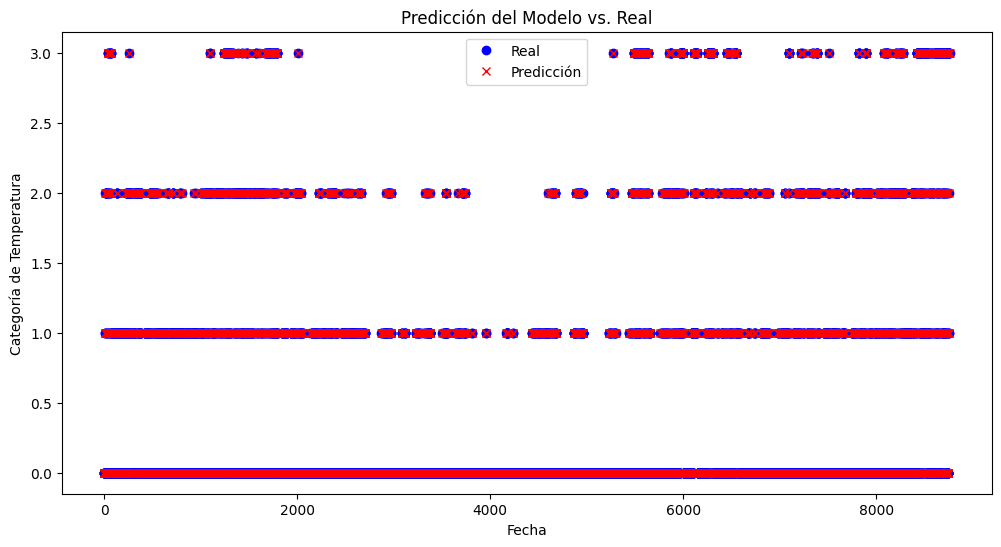

In [ ]:
import matplotlib.pyplot as plt

y_prueba_df = pd.DataFrame(y_prueba, columns=y.columns)

# Graficar la predicción del modelo
plt.figure(figsize=(12, 6))
plt.plot(y_prueba_df.index, np.argmax(y_prueba_df.values, axis=1), label='Real', color='blue', marker='o', linestyle='None')
plt.plot(y_prueba_df.index, y_pred_classes, label='Predicción', color='red', marker='x', linestyle='None')
plt.title('Predicción del Modelo vs. Real')
plt.xlabel('Fecha')
plt.ylabel('Categoría de Temperatura')
plt.legend()
plt.show()
